## Personalized Medicine: Redefining Cancer Treatment
<Br>    </Br>
Based on the type of gene mutation, a unique cancer treatment is tailored and provided to the patient. One of the significant steps in identifying the personalized medicince for cancer treatment is <u>finding the type (or class) of gene mutation</u>.
<Br>    </Br>
#### <B>Objective:</B>  
Classify the gene mutation into one of 9 classes based on clinical evidence from literature
<Br>    </Br>

#### <B>Machine learning problem:</B>  
Multi-class classification problem with categorical and text features as input.
<Br></Br> 

#### <B>Model metric</B>: 
Primary: Logloss Secondary: Confusion matrix
<Br></Br> 

#### <B>Data source:</B> 
https://www.kaggle.com/c/msk-redefining-cancer-treatment/data
Input files: 
    - File 1 contains information on gene, gene variation and the class of gene mutation (target feature)
    - File 2 contains clinical evidence (information from medical literature). This is in free text form


In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, kstest
import re
import collections
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.preprocessing import normalize
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer 
from sklearn.dummy import DummyClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, confusion_matrix,accuracy_score, precision_recall_fscore_support
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore")
import nltk
nltk.download('wordnet')
import scispacy
import spacy
import en_core_sci_sm, en_core_web_sm
from wordcloud import WordCloud

[nltk_data] Downloading package wordnet to /Users/archana/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
## Import input dataset - Training data
tr_var = pd.read_csv("training_variants")
tr_var.head(3)

ID    Gene             Variation  Class
0   0  FAM58A  Truncating Mutations      1
1   1     CBL                 W802*      2
2   2     CBL                 Q249E      2

In [3]:
tr_text = pd.read_csv("training_text", sep = '\|\|',skiprows=1, names=['ID', "Text"], engine='python')
tr_text.head(2)

ID                                               Text
0   0  Cyclin-dependent kinases (CDKs) regulate a var...
1   1   Abstract Background  Non-small cell lung canc...

Gene, Variation and Text are input features. Class is the output to be predicted. 

In [4]:
#Merge the two dataframes
df = pd.merge(tr_var,tr_text,on='ID',how = 'left')
print("The dataframe has {0} rows and {1} columns ".format(df.shape[0], df.shape[1]))
df.sample(3)

The dataframe has 3321 rows and 5 columns 


ID    Gene      Variation  Class  \
2312  2312    JAK1         G1079D      7   
148    148    EGFR          G724S      7   
3108  3108  DNMT3B  Amplification      2   

                                                   Text  
2312  A systematic characterization of the genetic a...  
148   Purpose: Recently, activating mutations of the...  
3108   Abstract Human cancers, including breast canc...

In [5]:
## Check for missing values
## Check for duplicates
## Check for unique values and number of unique values
print(df.info())
print("Duplicate rows present in the dataset?", df.duplicated().any())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 5 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
Text         3316 non-null object
dtypes: int64(2), object(3)
memory usage: 155.7+ KB
None
Duplicate rows present in the dataset? False


- There are 3321 records with 5 features
- Text feature has 5 missing values. All other features does not have any missing values
- There are no duplicated rows in the dataframe


### 1. Data Cleaning 
#### Impute Missing values
Text features has missing values
	- The target class for the record with missing text is identified and the most frequent text in that target class is imputed

In [11]:
#Filling missing values

#capture the most frequent value for every class in a dictionary
Text_mode = df.groupby('Class')['Text'].apply(lambda x: x.value_counts().index[0]).to_dict()
df.Text= df.apply(lambda x: Text_mode[x.Class] if pd.isnull(x.Text) else x.Text, axis =1)

In [12]:
# Is there any missing text?
print(df.Text.isnull().any())

False


In [6]:
print("Number of unique IDs:",df.ID.nunique())

Number of unique IDs: 3321


IDs are unique for every record and it will be dropped 

### 2. Spliting of data into train, cv and test

In [15]:
## Split the dataset into train, CV and test datasets
X = df.drop(columns = ['ID']) # ['Class', 'ID'])
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, stratify = y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train,y_train, test_size = 0.2, stratify = y_train)
print('''Shape of split datasets:
      X_train - {} and y_train - {}, 
      X_cv - {} and y_cv - {},
      X_test - {} and y_test - {}'''
      .format(X_train.shape,X_cv.shape, X_test.shape, y_train.shape,y_cv.shape, y_test.shape,))


Shape of split datasets:
      X_train - (2124, 4) and y_train - (532, 4), 
      X_cv - (665, 4) and y_cv - (2124,),
      X_test - (532,) and y_test - (665,)


### 3. Exploratory Data Analysis
#### 3.1. Univariate analysis

##### 3.1 Univariate Analysis: Class (target variable)

In [16]:
# Is this a imbalanced dataset?
y_dist = pd.concat([y_train, y_cv, y_test], axis =1)#,names = ['y_train', 'y_cv', 'y_test'])
y_dist.columns = ['Train','CV', 'Test']
print("Frequency of classes in the datasets")
y_dist.apply(pd.Series.value_counts).sort_index()

Frequency of classes in the datasets


Train   CV  Test
1.0    363   91   114
2.0    289   72    91
3.0     57   14    18
4.0    439  110   137
5.0    155   39    48
6.0    176   44    55
7.0    609  153   191
8.0     12    3     4
9.0     24    6     7

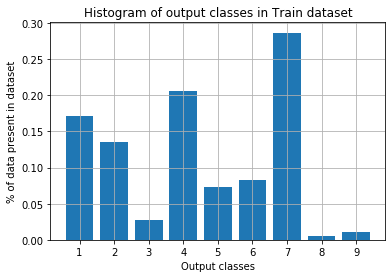

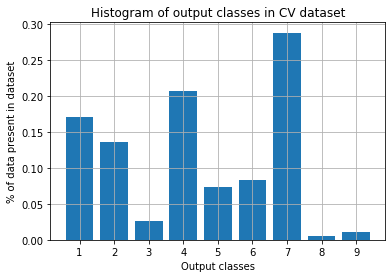

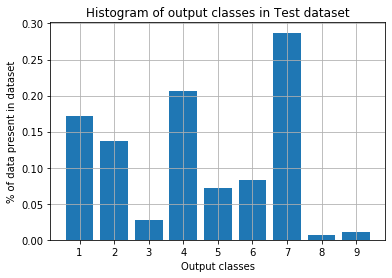

In [17]:
### Histogram of classes present in train, cv and test datasets

for column in y_dist:
    plt.title("Histogram of output classes in " + column +" dataset")
    plt.hist(y_dist[column], density = True,bins = np.arange(0.5,10.5), rwidth = 0.8)
    plt.xlabel("Output classes")
    plt.ylabel("% of data present in dataset")
    plt.xticks(np.arange(1,10))
    plt.grid()  
    plt.show()


- This is an imbalanced dataset
- All the three datasets -Train, CV and test - have similar distribution classes
- Class '7' is the most frequent class constituting >27% of the data

In [14]:
# df.Gene = df.Gene.str.lower()
# df.Variation = df.Variation.str.lower()
# #df.select_dtypes(exclude ='int').apply(lambda x: x.str.lower())

##### 3.2 Univariate Analysis: Gene

3.2.1 How many genes are there and how is it distributed?

In [18]:
gene_val_count = X_train.Gene.value_counts(normalize = True)
gene_val_count#[:10]

BRCA1     0.081921
TP53      0.048964
EGFR      0.040960
PTEN      0.038606
BRCA2     0.038136
            ...   
RAD51B    0.000471
CCNE1     0.000471
GNAQ      0.000471
RXRA      0.000471
DNMT3A    0.000471
Name: Gene, Length: 235, dtype: float64

In [19]:
print("There are {} unique Genes present in the train dataset".format(gene_val_count.shape[0]))

There are 235 unique Genes present in the train dataset


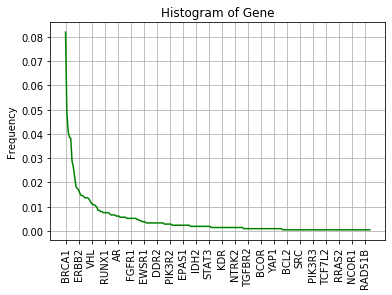

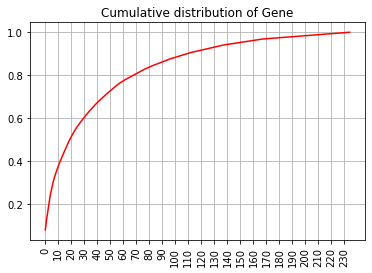

In [20]:
#Distribution of Genes feature
plt.title("Histogram of Gene")
plt.plot(gene_val_count.index, gene_val_count, color = 'g')
# plt.hist(X_train.Gene, bins = 240)
plt.xticks(ticks = list(range(0, len(gene_val_count.index), 10)),rotation = 90)
plt.ylabel("Frequency")
plt.grid()
plt.show()

plt.title("Cumulative distribution of Gene")
plt.plot(range(0,len(gene_val_count)), np.cumsum(gene_val_count), color = 'r')
plt.xticks(ticks = list(range(0, 240, 10)),rotation = 90)
plt.grid()
plt.show()

- BRCA1 is the most frequent gene in the training dataset
- From the Gene histogram, it looks like Gene feature follows power law distribution. Let us check with a K-S test

In [28]:
from scipy.stats import probplot, pareto, genpareto
kstest(gene_val_count, 'expon')
#kstest(gene_val_count, 'genpareto', args =(0.0001,))
#Generalized exponential function
#_,_ = probplot(gene_val_count,dist = 'genexpon', sparams=(120,1,100), fit = True, plot =plt)
#_,_ = probplot(gene_val_count,dist = 'genpareto', sparams=(10,), fit = True, plot =plt)

KstestResult(statistic=0.9513564517446672, pvalue=5.64890068846801e-309)

Kolgomrov-Smirnov's hypothesis test:Gene feature does not follow exponential distribution as the null hypothesis is rejected with a p-value of zero

In [29]:
print("Out of {} genes, 50 genes constitutes >75% of the data".format(gene_val_count.shape[0]))

Out of 235 genes, 50 genes constitutes >75% of the data


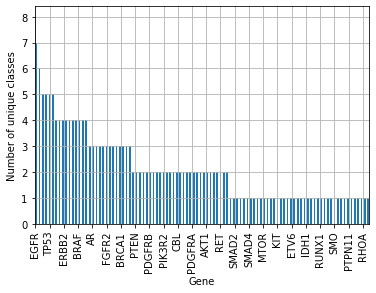

In [30]:
# How many unique number of classes can a gene be classified into?
gene_class = X_train.groupby('Gene')['Class'].nunique().sort_values(ascending = False)#.plot()
gene_class.plot(kind = 'bar')
plt.xticks(ticks = list(range(0, len(gene_val_count.index), 10)),rotation = 90)
plt.ylabel("Number of unique classes")
plt.grid()
plt.show()

In [59]:
print(f"Among the {gene_class.shape[0]} unique genes, {(gene_class[gene_class == 1].shape[0]/gene_class.shape[0])*100}% is categorized into one unique gene mutation class type")
#print("Thus, with the given training data, gene feature alone can classify 42% of gene mutations correctly")

Among the 235 unique genes, 41.702127659574465% is categorized into one unique gene mutation class type


3.2.2 How stable is the gene feature across train, cv and test datasets?    

In [32]:
## How stable is Gene feature?
print("Train:", sum(X_train.Gene.isin(set(X_train.Gene)))/X_train.Gene.shape[0])
print("cv:", sum(X_cv.Gene.isin(set(X_train.Gene)))/X_cv.Gene.shape[0])
print("Test:", sum(X_test.Gene.isin(set(X_train.Gene)))/X_test.Gene.shape[0])

Train: 1.0
cv: 0.9699248120300752
Test: 0.9774436090225563


There is ~96% of data overlap between cv and train Gene data, and test and Gene train data and thus this is a stable feature

3.2.3 Is Gene feature significant for this model?
    - Let's model the gene feature alone with output and check its performance and compare it with a random model
    
        1.1.3.1 Preprocessing of Gene Feature
        1.1.3.2 Defining logloss as classification metric
        1.1.3.3 Defining a random model and setting its ogloss as baseline score
        1.1.3.4 Modeling of Gene feature with MNB and Logistic regression and finding its significnce

3.2.3.1 Preprocessing of Gene Feature:
    - One hot encoding
    - Response encoding

In [33]:
#3.2.3.1 Preprocessing of Gene Feature:
### Gene is a categorical feature and it has to be converted to numerical feature
### Two types of encoding - response encoding and one hot encoding. Reponse encoding will be used with 
### Multinomial NB and random forest whereas one hot encoded will be used with linear models

def onehotencoding(feature, df):
    '''Returns one hot encoded numerical array of given categorical feature'''
    ohe = OneHotEncoder(handle_unknown='ignore') ## All categories that are not captured in training are set as 0
    ohe.fit(df[feature].values.reshape(-1,1))
    return ohe

def response_coding(feature, df, alpha, k=9):
    '''Returns a tuple of feature categories and their response encoded 9-dimensional numerical 
    array of the given feature. Logic used: Converts category into P(y|Gene) for every class.
    9-dimensional array containing probability for every class:
    [P(y=1|gene'A') = P(y=1 and gene'A') /P(gene'A'),
    P(y=2|gene'A') = P(y=2 and gene'A') /P(gene'A'),
    .
    .
    P(y=9|gene'A') = P(y=9 and gene'A') /P(gene'A')]
    Laplace smoothing included to avoid zero probability
    '''

    feat_unique = df[feature].unique()
    feat_dict = {}
    ## Assigning alpha and k for Laplace smoothing
    for category in feat_unique:
        vector = np.zeros(9)
        total = sum(df[feature]== category) #Total number of observations for category
        class_prob = (df[df[feature]== category].groupby('Class')[feature].count() + alpha)/(total +alpha*k)
        for i in class_prob.index:
            vector[i-1] = class_prob[i]
        feat_dict[category] = vector
        
    return ([name for name in feat_dict.keys()], np.array([feat_dict[g] for g in df[feature].values]))

In [34]:
### Gene: Reponse coding

gene_rc_train = response_coding('Gene', X_train, 1)[1]
gene_rc_cv = response_coding('Gene', X_cv, 1)[1]
gene_rc_test = response_coding('Gene', X_test, 1)[1]

print(gene_rc_train.shape)
print(gene_rc_cv.shape)
print(gene_rc_test.shape)

(2124, 9)
(532, 9)
(665, 9)


In [35]:
#Normalize response encoded gene
gene_rc_train_norm = normalize(gene_rc_train, axis=0)
gene_rc_cv_norm = normalize(gene_rc_cv, axis=0)
gene_rc_test_norm = normalize(gene_rc_test, axis=0)

print(gene_rc_train_norm.shape)
print(gene_rc_cv_norm.shape)
print(gene_rc_test_norm.shape)

(2124, 9)
(532, 9)
(665, 9)


In [36]:
#One hot encoding of Gene feature
ohe_gene = onehotencoding('Gene', X_train)
gene_ohe_train = ohe_gene.transform(X_train.Gene.values.reshape(-1,1))
gene_ohe_cv = ohe_gene.transform(X_cv.Gene.values.reshape(-1,1))
gene_ohe_test = ohe_gene.transform(X_test.Gene.values.reshape(-1,1))

print(gene_ohe_train.shape)
print(gene_ohe_cv.shape)
print(gene_ohe_test.shape)

(2124, 235)
(532, 235)
(665, 235)


In [37]:
#Normalize one hot vectorized gene
gene_ohe_train_norm = normalize(gene_ohe_train, axis=0)
gene_ohe_cv_norm = normalize(gene_ohe_cv, axis=0)
gene_ohe_test_norm = normalize(gene_ohe_test, axis=0)

print(gene_ohe_train_norm.shape)
print(gene_ohe_cv_norm.shape)
print(gene_ohe_test_norm.shape)

(2124, 235)
(532, 235)
(665, 235)


In [38]:
gene_ohe_features = ohe_gene.categories_[0]
gene_ohe_features

array(['ABL1', 'ACVR1', 'AGO2', 'AKT1', 'AKT2', 'AKT3', 'ALK', 'APC',
       'AR', 'ARAF', 'ARID1B', 'ARID2', 'ARID5B', 'ASXL1', 'ATM', 'ATRX',
       'AURKA', 'AURKB', 'AXIN1', 'AXL', 'B2M', 'BAP1', 'BARD1', 'BCL10',
       'BCL2', 'BCL2L11', 'BCOR', 'BRAF', 'BRCA1', 'BRCA2', 'BRD4',
       'BRIP1', 'BTK', 'CARD11', 'CARM1', 'CASP8', 'CBL', 'CCND1',
       'CCND2', 'CCND3', 'CCNE1', 'CDH1', 'CDK12', 'CDK4', 'CDK6', 'CDK8',
       'CDKN1A', 'CDKN1B', 'CDKN2A', 'CDKN2B', 'CEBPA', 'CHEK2', 'CIC',
       'CREBBP', 'CTCF', 'CTLA4', 'CTNNB1', 'DDR2', 'DICER1', 'DNMT3A',
       'DNMT3B', 'DUSP4', 'EGFR', 'EIF1AX', 'ELF3', 'EP300', 'EPAS1',
       'ERBB2', 'ERBB3', 'ERBB4', 'ERCC2', 'ERCC3', 'ERCC4', 'ERG',
       'ERRFI1', 'ESR1', 'ETV1', 'ETV6', 'EWSR1', 'EZH2', 'FANCA', 'FAT1',
       'FBXW7', 'FGF3', 'FGFR1', 'FGFR2', 'FGFR3', 'FGFR4', 'FLT1',
       'FLT3', 'FOXA1', 'FOXL2', 'FUBP1', 'GATA3', 'GNA11', 'GNAQ',
       'GNAS', 'H3F3A', 'HIST1H1C', 'HLA-B', 'HNF1A', 'HRAS', 'IDH1',
       'I

- 3.2.3.2 Defining logloss as classification metric
- 3.2.3.3 Defining a random model and setting its logloss as baseline score

In [39]:
# 3.2.3.2 Defining logloss as classification metric
def classification_metric(truey, model, x):
    '''Returns the logistic loss and confusion matrix of the model'''
    y = model.predict(x)
    y_prob = model.predict_proba(x)
    return log_loss(truey, y_prob), confusion_matrix(truey, y)

# 3.2.3.3 Defining a random model and setting its logloss as baseline score
def random_model(x_data_len, truey):
    '''Returns the logistic loss for a randomly generated probabilities for 9-classes.
    No input is provided to this random model, as random model does not depend on the 
    pattern in input data but rather on simple rules.'''
    logloss = 0
    rand_model_prob = np.zeros((x_data_len, 9))
    for i in range(x_data_len): #training data length
        rand_prob = np.random.normal(0.5,0.1,9)/np.sum(np.random.normal(0.5,0.1,9))
        rand_model_prob[0] = rand_prob
    return log_loss(truey, rand_model_prob)

In [40]:
### Dummy classifier
# print("*"*20 + "Dummy model from Sklearn" + "*"*20)
# dummy = DummyClassifier(strategy='uniform')
# dummy.fit(gene_rc_train,y_train)
# print("Train:\n", classification_metric(y_train, dummy, gene_rc_train)[0])
# print("cv:\n", classification_metric(y_cv, dummy, gene_rc_cv)[0])
# print("Test:\n", classification_metric(y_test, dummy, gene_rc_test)[0])
print("*"*20 + "Random model" + "*"*20)
print("Train:\n", random_model(gene_rc_train.shape[0], y_train))
print("cv:\n", random_model(gene_rc_cv.shape[0], y_cv))
print("Test:\n", random_model(gene_rc_test.shape[0], y_test))

********************Random model********************
Train:
 2.1971800785400153
cv:
 2.1971507950285827
Test:
 2.1970951816734714


The logistic loss from random model is ~2.2. If the logistic loss from feature models (Gene alone) is less than this 2.2, we can consider it as significant in predicting the output

### 3.2.3.4 Modeling of Gene feature with MNB and Logistic regression and finding its significnce

In [41]:
def multi_nb(xtrain, ytrain, xcv, ycv, xtest, ytest):
    '''Returns the logistic loss from a multinomial naive bayes model of the given data. Performs
    cross validation to find the optimal hyper parameter and provides the logistic loss of test 
    data'''
    alpha = [1e-6, 1e-5,1e-4, 1e-3, 1e-2, 1e-1, 0, 1]
    logloss = []
    for a in alpha:
        mnb = MultinomialNB(alpha=a)
        mnb.fit(xtrain,ytrain)
        logloss.append(classification_metric(ycv, mnb, xcv)[0])
    a = alpha[logloss.index(min(logloss))]
    mnb = MultinomialNB(alpha=a)
    mnb.fit(xtrain,ytrain)
    return classification_metric(ytest, mnb, xtest)[0]

def sgd_classifier(xtrain, ytrain, xcv, ycv, xtest, ytest, loss = 'log'):
    '''Returns the logistic loss from a Stochastic Gradient Descent model of the given data.
    Performs cross validation to find the optimal hyper parameter and provides the logistic loss 
    of test data'''
    alpha = [1e-6, 1e-5,1e-4, 1e-3, 1e-2, 1e-1, 1]
    logloss = []
    for a in alpha:
        sgd = SGDClassifier(alpha = a, loss = loss)
        sgd.fit(xtrain,ytrain)
        logloss.append(classification_metric(ycv, sgd, xcv)[0])
    a = alpha[logloss.index(min(logloss))]
    sgd = SGDClassifier(alpha = a, loss = loss)
    sgd.fit(xtrain,ytrain)
    return classification_metric(ytest, sgd, xtest)#[0]


In [43]:
### Is Gene feature significant?
### Modeling response coded gene feature with Multinomial Naive Bayes
print("Logistic loss from Multinomial Naive Bayes model of response coded Gene feature:")
print("{:.6f}".format(multi_nb(gene_rc_train,y_train,gene_rc_cv,y_cv, gene_rc_test, y_test)))
print("Logistic loss from Logistic regression model of one hot encoded Gene feature:")
print("{:.6f}".format(sgd_classifier(gene_ohe_train,y_train,gene_ohe_cv,y_cv, gene_ohe_test, y_test)[0]))

Logistic loss from Multinomial Naive Bayes model of response coded Gene feature:
1.376860
Logistic loss from Logistic regression model of one hot encoded Gene feature:
1.150457


Logistic loss from Gene feature (from both multinomial and logistic regression) is lower than that from a random model. Thus, Gene feature has significance to the output and this feature will be retained in the model

### 3.3 Univariate Analysis: Variation
##### Variation is a feature that indicates how the original gene is modified

3.3.1 How many unique variation feature is present? and how is it distributed?

In [44]:
nunique = X_train.Variation.nunique()
X_train.Variation.value_counts()

Truncating Mutations    59
Amplification           48
Deletion                48
Fusions                 24
Overexpression           5
                        ..
V579A                    1
C420R                    1
N540S                    1
R133H                    1
BCR-FGFR1 Fusion         1
Name: Variation, Length: 1925, dtype: int64

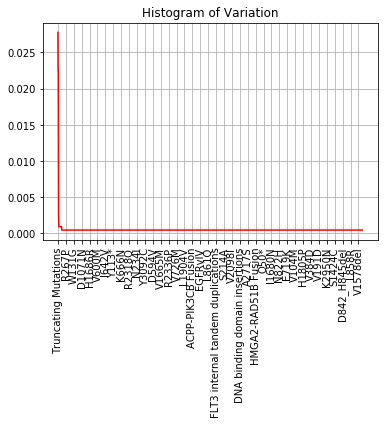

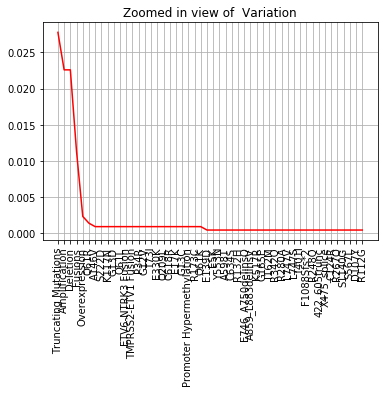

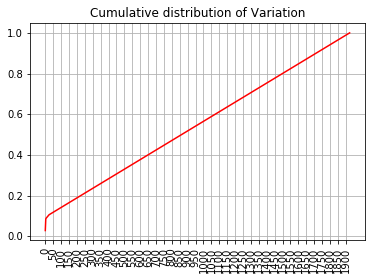

In [45]:
### Univariate analysis: Variation
var_val_count = X_train.Variation.value_counts(normalize = True)
plt.title("Histogram of Variation")
plt.plot(var_val_count.index, var_val_count, color = 'r')
# plt.hist(X_train.Gene, bins = 240)
plt.xticks(ticks = list(range(0, len(var_val_count), 50)),rotation = 90)
plt.grid()
plt.show()

plt.title("Zoomed in view of  Variation")
plt.plot(var_val_count.index[:50], var_val_count[:50], color = 'r')
# plt.hist(X_train.Gene, bins = 240)
plt.xticks(rotation = 90)
plt.grid()
plt.show()

plt.title("Cumulative distribution of Variation")
plt.plot(range(0,nunique), np.cumsum(var_val_count), color = 'r')
# plt.hist(X_train.Gene, bins = 240)
plt.xticks(ticks = list(range(0, var_val_count.shape[0], 50)),rotation = 90)
plt.grid()
plt.show()

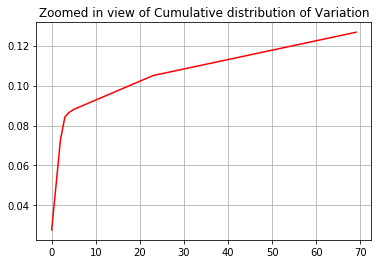

In [46]:
plt.title("Zoomed in view of Cumulative distribution of Variation")
plt.plot(range(0,70), np.cumsum(var_val_count)[:70], color = 'r')
# plt.hist(X_train.Gene, bins = 240)
#plt.xticks(ticks = list(range(0, total, 50)),rotation = 90)
plt.grid()
plt.show()

In [47]:
print("- There are {} unique variations present in the training dataset".format(nunique))
print("- Most commonly occured gene variation is 'Truncating Mutations'")
print("- Though the distribution of variation feature resembles a 'L-shaped distribution', > 80% \
of the data follows uniform distribution")

- There are 1925 unique variations present in the training dataset
- Most commonly occured gene variation is 'Truncating Mutations'
- Though the distribution of variation feature resembles a 'L-shaped distribution', > 80% of the data follows uniform distribution


3.3.2. How is the gene mutation class distributed among the Variation feature?

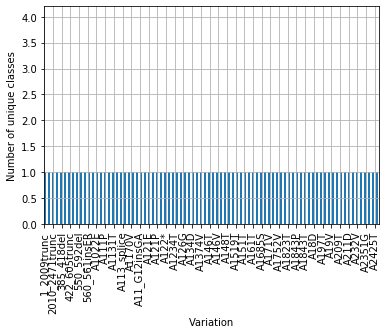

In [48]:
variation_class = X_train.groupby('Variation')['Class'].nunique()
#variation_class[variation_class > 1].shape
variation_class.plot(kind = 'bar')
plt.xticks(ticks = list(range(0, variation_class.shape[0], 50)),rotation = 90)
plt.ylabel("Number of unique classes")
plt.grid()

In [58]:
print("- Gene mutation class is distributed uniformly across the variation feature")
print(f"- Among the {variation_class.shape[0]} unique gene variations, {(variation_class[variation_class == 1].shape[0]/variation_class.shape[0])*100}% is categorized into one unique gene mutation class type")
#print("- Thus, variation feature alone can classify these genes correctly")

- Gene mutation class is distributed uniformly across the variation feature
- Among the 1925 unique gene variations, 99.32467532467533% is categorized into one unique gene mutation class type


3.3.3 Is the Variation feature significant for gene mutation class classification?

In [50]:
## Response encoding of variation feature
var_rc_train = response_coding('Variation',X_train,1)[1]
var_rc_cv = response_coding('Variation',X_cv,1)[1]
var_rc_test = response_coding('Variation',X_test,1)[1]

print(var_rc_train.shape)
print(var_rc_cv.shape)
print(var_rc_test.shape)

(2124, 9)
(532, 9)
(665, 9)


In [51]:
#Normalize vectorized gene
var_rc_train_norm = normalize(var_rc_train, axis=0)
var_rc_cv_norm = normalize(var_rc_cv, axis=0)
var_rc_test_norm = normalize(var_rc_test, axis=0)

print(var_rc_train_norm.shape)
print(var_rc_cv_norm.shape)
print(var_rc_test_norm.shape)

(2124, 9)
(532, 9)
(665, 9)


In [52]:
ohe_var = onehotencoding('Variation', X_train)
var_ohe_train = ohe_var.transform(X_train.Variation.values.reshape(-1,1))
var_ohe_cv = ohe_var.transform(X_cv.Variation.values.reshape(-1,1))
var_ohe_test = ohe_var.transform(X_test.Variation.values.reshape(-1,1))

print(var_ohe_train.shape)
print(var_ohe_cv.shape)
print(var_ohe_test.shape)


(2124, 1925)
(532, 1925)
(665, 1925)


In [53]:
#Normalize vectorized text
var_ohe_train_norm = normalize(var_ohe_train, axis=0)
var_ohe_cv_norm = normalize(var_ohe_cv, axis=0)
var_ohe_test_norm = normalize(var_ohe_test, axis=0)

print(var_ohe_train_norm.shape)
print(var_ohe_cv_norm.shape)
print(var_ohe_test_norm.shape)

(2124, 1925)
(532, 1925)
(665, 1925)


In [54]:
var_ohe_features = ohe_var.categories_[0]
var_ohe_features

array(['1_2009trunc', '2010_2471trunc', '385_418del', ...,
       'YAP1-FAM118B Fusion', 'ZC3H7B-BCOR Fusion', 'ZNF198-FGFR1 Fusion'],
      dtype=object)

In [56]:
### Is Variation feature significant?
### Modeling response coded Variation feature with Multinomial Naive Bayes
print("Logistic loss from Multinomial Naive Bayes model of response coded Gene feature:")
print("{:.6f}".format(multi_nb(var_rc_train,y_train,var_rc_cv,y_cv, var_rc_test, y_test)))
### Modeling one hot encoded Variation feature with Logistic regression
print("Logistic loss from Logistic regression model of one hot encoded Gene feature:")
print("{:.6f}".format(sgd_classifier(var_ohe_train,y_train,var_ohe_cv,y_cv, var_ohe_test, y_test)[0]))

Logistic loss from Multinomial Naive Bayes model of response coded Gene feature:
0.801367
Logistic loss from Logistic regression model of one hot encoded Gene feature:
1.764774


Logistic loss from both MultiNB and SGD classifier of Variation feature is lower than that from a random model. Thus, Variation feature has significance to the output and this feature will be retained in the model

3.3.4 How stable is the variation feature across train, test and cv datasets?

In [57]:
#How stable is the Variation feature?
print("Train:", sum(X_train.Variation.isin(set(X_train.Variation)))/X_train.Variation.shape[0])
print("cv:", sum(X_cv.Variation.isin(set(X_train.Variation)))/X_cv.Variation.shape[0])
print("Test:", sum(X_test.Variation.isin(set(X_train.Variation)))/X_test.Variation.shape[0])

Train: 1.0
cv: 0.12218045112781954
Test: 0.07819548872180451


- Variation CV dataset contains only ~12% overlap with the train dataset. It contains about 88% of categories that are not present in train dataset
- Variation Test dataset contains only ~7% of overlap with the train dataset. It contains about 93% of categories that are not present in train dataset
- <u>Variation feature</u> as such is an <u>unstable feature</u>, but since its logistic loss is higher than that of the random model, it will be retained

### 3.4 Univariate Analysis: Text
##### Text is a feature that contains the clinical evidence

#### 3.4.1 What kind of text is present and what kind of preprocessing is required?

In [60]:
df.Text[1709]

"Tumors with somatic mutations in the proofreading exonuclease domain of DNA polymerase epsilon (POLE-exo*) exhibit a novel mutator phenotype, with markedly elevated TCT→TAT and TCG→TTG mutations and overall mutation frequencies often exceeding 100 mutations/Mb. Here, we identify POLE-exo* tumors in numerous cancers and classify them into two groups, A and B, according to their mutational properties. Group A mutants are found only in POLE, whereas Group B mutants are found in POLE and POLD1 and appear to be nonfunctional. In Group A, cell-free polymerase assays confirm that mutations in the exonuclease domain result in high mutation frequencies with a preference for C→A mutation. We describe the patterns of amino acid substitutions caused by POLE-exo* and compare them to other tumor types. The nucleotide preference of POLE-exo* leads to increased frequencies of recurrent nonsense mutations in key tumor suppressors such as TP53, ATM, and PIK3R1. We further demonstrate that strand-specif

- Text is clinical evidence from medical literature
- These are short or long excerpts from medical literature and text preprocessing is required to remove the following:
	- English stop words
	- Scientific stop words such as figure, table, supplementary figure, abstract, conclusion, study, describe, et al.,Materials and methods, e.g., reviewed, experimental procedures, Introduction, Results, Discussion, Methods, Additional information, References, Acknowledgments, Author information and Supplementary information, shown, analysis, found, therefore, whether, reported, using, etc
	- Noise: references to other articles - authors, years, reference numbers auch as [12] or (3,7), web links,
	- Special characters such as chi2, beta, gamma, <,> / ;,,.,.
	- Tab sequences: \t
- Some special characters needs to be retained. Examples below
     - arrow in TCT→TAT, hyphen and star in POLE-exo*
     - hyphen and slash in 5′-GGTGTTCAGGGAGGCCTAAT-3′/5′-CCCATCCCAGGAGCTTACTT-3′
     - dot in p.P286
     - alpha and beta in pcDNA3-HA-p73α and
     - brackets as in 3-[(3-cholamidopropyl)dimethylammonio]-1- ?
- There are several abbreviations in the text. They need to be captured -- example: 'EGFR': 'epidermal growth factor receptor'

Following procedure will be performed before univariate analysis of text feature
    1. Text preprocessing
        1.1 Scientific (medical) text preprocessing with scispacy
        1.2 English text preprocessing
    2. Vectorization
        2.1 Count Vectorizer
        2.2 Term Frequency Inverse Document Frequency (tf-idf) vectorizer

1.1 Scientific (medical) text preprocessing with scispacy

In [118]:
nlp_spacy = en_core_sci_sm.load()

def scispacy_preprocesser(doc):
    '''Returns preprocessed, tokenized features from the given documents'''
    doc = nlp_spacy(doc)
    spacy_tokens = doc.ents
    return [token.text for token in spacy_tokens]

def noise_removal_scispacy(text_series):
    '''Remove all the noise from the text'''
    lemma = WordNetLemmatizer()
    stop_words = {'mutation', 'mutations', 'variant', 'variants', 'study', 'data', 'gene', 
                  'activity', 'detected', }
    for index, text_data in text_series.iteritems():
        if type(text_data) == str:
            text_data = re.sub(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '', text_data) # remove tables
            #text_data = re.sub('[F|f]ig\w{0,3}\\b', '', text_data) #remove fig, figures
            #text_data = re.sub('\\b[T|t]able(?!t)', '', text_data) #remove tables
            #text_data = text_data.lower() 
            text = ""
            for word in text_data.split():
                text += lemma.lemmatize(word) + " "
            text_series[index] = text
    return None

In [119]:
X_train_ss = X_train.copy()
X_cv_ss = X_cv.copy()
X_test_ss = X_test.copy()

noise_removal_scispacy(X_train_ss.Text)
noise_removal_scispacy(X_cv_ss.Text)
noise_removal_scispacy(X_test_ss.Text)

In [120]:
countvectorize = CountVectorizer(analyzer=scispacy_preprocesser)
countvectorize.fit_transform(X_train_ss.Text)

<2124x387866 sparse matrix of type '<class 'numpy.int64'>'
	with 2662730 stored elements in Compressed Sparse Row format>

In [121]:
text_ohe_train_scispacy = countvectorize.transform(X_train_ss['Text'])

In [122]:
text_ohe_cv_scispacy = countvectorize.transform(X_cv_ss['Text'])

In [123]:
text_ohe_test_scispacy = countvectorize.transform(X_test_ss['Text'])

In [124]:
text_ohe_train_scispacy_norm = normalize(text_ohe_train_scispacy)
text_ohe_cv_scispacy_norm = normalize(text_ohe_cv_scispacy)
text_ohe_test_scispacy_norm = normalize(text_ohe_test_scispacy)

In [125]:
print(text_ohe_train_scispacy_norm.shape)
print(text_ohe_cv_scispacy_norm.shape)
print(text_ohe_test_scispacy_norm.shape)

(2124, 387866)
(532, 387866)
(665, 387866)


In [126]:
countvectorize.vocabulary_

{'Androgen receptor': 14623,
 'AR': 9790,
 'mutation': 303696,
 'associated with': 207109,
 'androgen insensitivity syndrome': 201560,
 'AIS': 8182,
 'Missense mutation': 118147,
 'AR-N-terminal domain': 9908,
 'AR-NTD': 9909,
 'rare': 341548,
 'clinical phenotype': 227489,
 'mild': 296421,
 'investigated': 280887,
 'missense mutation': 297344,
 'insertion/deletions': 277850,
 'study': 362210,
 'pathogenic': 324621,
 'mutant': 303241,
 'AR-NTD function': 9912,
 'Q120E': 144800,
 'A159T': 6157,
 'G216R': 70638,
 'G248V': 70693,
 'L272F': 101995,
 'P380R': 132404,
 'AR-expression': 9993,
 'plasmids': 329826,
 'Stably': 169239,
 'cell line': 220877,
 'del57L': 239426,
 'ins58L': 277749,
 'Transactivation': 180561,
 'measured': 292655,
 'luciferase reporter': 288947,
 'control': 233087,
 'GRE': 74043,
 'Pem promoters': 139840,
 'Intrinsic fluorescence spectroscopy': 93801,
 'partial proteolysis study': 324287,
 'reduced': 343995,
 'activity': 196633,
 'AR-AF1 protein': 9891,
 'luciferase r

In [641]:
# text_feat_names_scispacy = countvectorize.get_feature_names()
# text_dict_scispacy = dict(zip(text_feat_names_scispacy,text_ohe_train_scispacy.sum(axis = 0).A1))

In [127]:
### Analysis of text frequency in the corpus    

def text_dictionary(text_feature_name, vectorized_train_X):
    '''Returns a dictionary of all the tokens from the Text feature training data with their 
    frequency or TF-IDF values'''
    return dict(zip(text_feature_name,vectorized_train_X.sum(axis = 0).A1))

def top_x_features_plot(text_feature_name, vectorized_train_X, n):
    text_dict = text_dictionary(text_feature_name, vectorized_train_X)
    text_frequency = pd.DataFrame.from_dict(text_dict, orient ='index').reset_index()
    text_frequency.rename({'index': 'word', 0:'frequency'}, axis =1, inplace = True)
    text_frequency_sorted = text_frequency.sort_values(by = 'frequency', ascending = False)[:n]
    plt.figure(figsize=(15,10))
    plt.bar(text_frequency_sorted.word, text_frequency_sorted.frequency)
    _ = plt.xticks(rotation = 90)
    plt.grid()
    plt.show()
    return text_frequency_sorted.word
    
def word_cloud_plot(text_feature_name, vectorized_train_X):
    '''Plots the word cloud plot of the given text'''
    text_dict = text_dictionary(text_feature_name, vectorized_train_X)
    # Create the wordcloud object
    wordcloud = WordCloud(font_path = 'Arial',max_words = 45000, width = 1600, height = 800, 
                          margin =0, include_numbers=True, 
                          colormap = 'Set1').generate_from_frequencies(text_dict)
    # Display the generated image:
    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
    
def top_n_words_per_target_class(text_feature_name, vectorized_train_X, n):
    '''Returns the n words with the highest frequency grouped by the target class'''
    vect_text_df = pd.DataFrame(data = vectorized_train_X, columns = text_feature_name)
    vect_text_df['Target'] = y_train.reset_index(drop = True)
    vect_text_df_sum = vect_text_df.groupby('Target').sum()

    return (pd.DataFrame({n: vect_text_df_sum.T[col].nlargest(20).index.tolist() 
                  for n, col in enumerate(vect_text_df_sum.T)}).T)

What are the top 50 words with highest frequency in the text corpus?

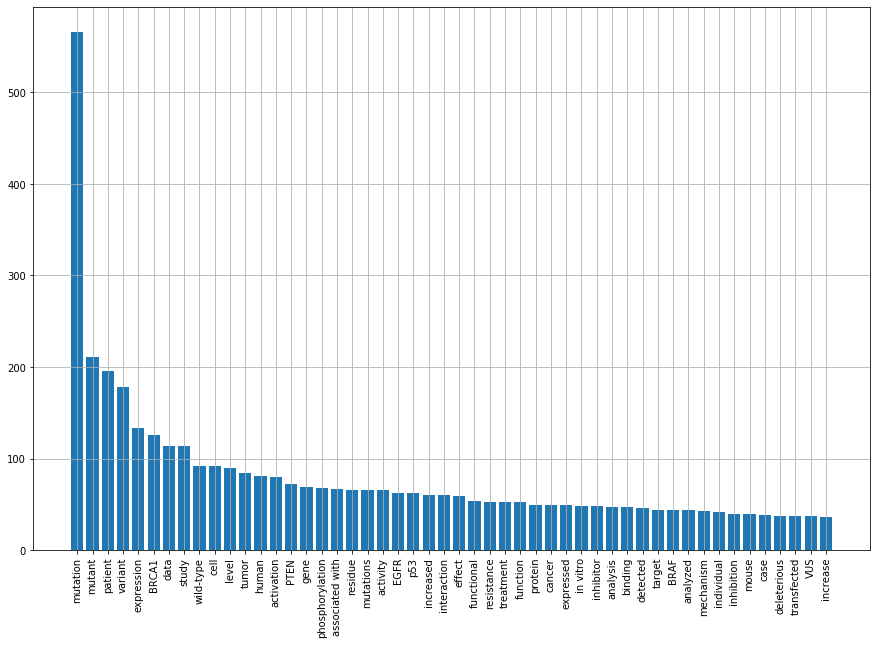

The top 50 words and their frequencies are 303696           mutation
303241             mutant
324953            patient
379631            variant
252770         expression
20904               BRCA1
238322               data
362210              study
382535          wild-type
220093               cell
285332              level
373601              tumor
272112              human
196157         activation
137804               PTEN
259863               gene
328831    phosphorylation
207109    associated with
346352            residue
304279          mutations
196633           activity
53888                EGFR
318948                p53
276265          increased
278618        interaction
247085             effect
258198         functional
346596         resistance
372390          treatment
258158           function
337523            protein
216742             cancer
252750          expressed
275669           in vitro
277204          inhibitor
201021           analysis
210951            bin

In [128]:
text_feat_names_scispacy = countvectorize.get_feature_names()
print("The top 50 words and their frequencies are", top_x_features_plot(text_feat_names_scispacy, text_ohe_train_scispacy_norm, 50))

Visualization of all the words and their frequencies

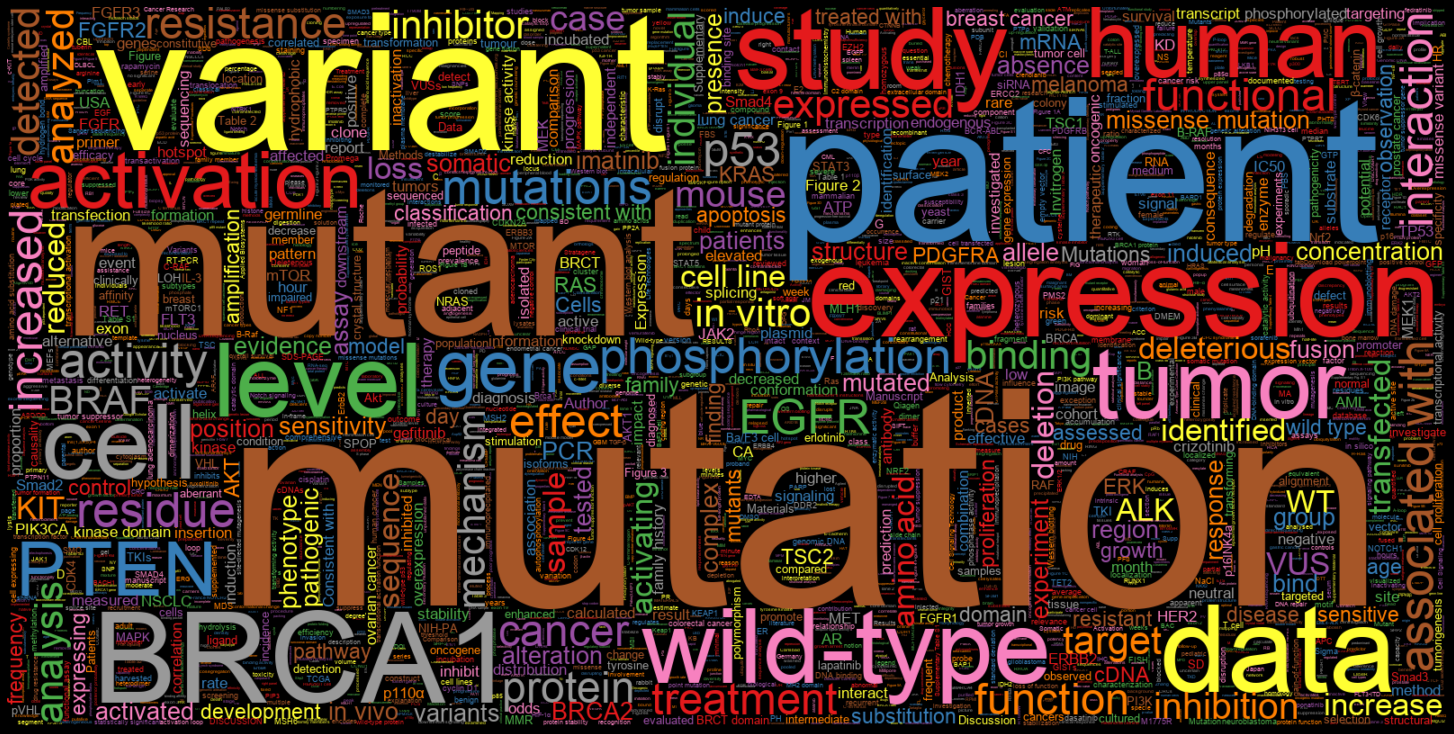

In [148]:
word_cloud_plot(text_feat_names_scispacy, text_ohe_train_scispacy_norm)

What are the top 20 words with highest frequency in the text corpus for every "target" class variable?

In [147]:
top_n_words_per_target_class(text_feat_names_scispacy, text_ohe_train_scispacy_norm.toarray(), 20)

0        1           2            3           4           5  \
0  mutation  variant      mutant          p53       BRCA1  expression   
1  mutation  patient      mutant        study        EGFR  expression   
2  mutation  variant       BRCA1       mutant     patient         ALK   
3  mutation     PTEN      mutant      variant  expression         p53   
4   variant    BRCA1    mutation          VUS      mutant  functional   
5  mutation  variant       BRCA1  deleterious       BRCA2        data   
6  mutation  patient      mutant   expression  activation        EGFR   
7  mutation     IDH1  expression         BCOR        IDH2        gene   
8  mutation   mutant       SF3B1         EZH2        IDH1    splicing   

            6                7          8           9           10  \
0     patient             data  wild-type       study        human   
1       tumor             BRAF        KIT   treatment         data   
2      PDGFRA       expression       FLT3        cell         mTOR   
3   wild-type             data    patient       BRCA1        level   
4        data        wild-type      study       assay        human   
5         VUS            study     mutant  resistance  interaction   
6       study  phosphorylation       cell       tumor         data   
7      mutant             data    patient       tumor         cell   
8  expression              MDS      level        gene    wild-type   

           11          12          13          14               15  \
0        gene       level        cell     residue            tumor   
1  activation    imatinib        gene  resistance           fusion   
2       human  activating       study  activation  phosphorylation   
3       study        cell    activity       human          residue   
4  expression    variants  pathogenic       level      deleterious   
5        BRCA  individual     patient       tumor             odds   
6       level  resistance       human   treatment        inhibitor   
7       level        Shp2         IDH         GBM            human   
8     patient          WT        IDH2        cell              AKT   

           16         17           18               19  
0  functional   function  interaction  associated with  
1   mutations      level         cell        inhibitor  
2        PTEN  mutations    wild-type            level  
3    function    protein       effect       functional  
4     patient   activity        BRCA2           Author  
5    variants   analysis      residue          neutral  
6        BRAF  wild-type          ALK        mutations  
7      sample  wild-type        study           allele  
8        data        IDH        study            H3K27

How significant is the "Text" feature in predicting class?

In [149]:
sgd_classifier(text_ohe_train_scispacy_norm.toarray(),y_train,text_ohe_cv_scispacy_norm.toarray(),y_cv, text_ohe_test_scispacy_norm.toarray(), y_test)[0]

1.0250776214992854

1.2 English text preprocessing

In [159]:
scientific_stop_words = {'et', 'al', 'figure', 'fig', 'abstract', 'background', 'go to', 'analyze', 'results',
 'materials','methods', 'table', 'reviewed', 'procedures', 'experimental', 'introduction',
 'author', 'information', 'show', 'find', 'found', 'study', 'result', 'conclusion', 'method', 
 'analysis', 'describe', 'supplementary', 'supplemental', 'shown', 'shows', 'using', 'table',
 'therefore', 'whether', 'reported', 'described', 'ref', 'discussion', 'references', 'acknowledge',
'determined', 'thus', 'performed', 'performing', 'follow', 'follows', 'following', 'examined', 
 'suggesting', 'observation', 'suggests', 'presents', 'presented', 'defined', 'suggest', 'also',
'figures', 'identified', 'validated', 'one', 'might', 'including', 'analyzed', 'recurrently',
'upon', 'however', 'suggest', 'showed', 'suggested', 'indicate', 'indicated', 'indicates',
'studies', 'used', 'observed', 'may', 'although', 'respectively', 'two', 'three', 'would', 
'published', 'reveal', 'revealed', 'display', 'displayed', 'demonstrated', 'since', 'report',
 'exhibited', 'given', 'expressed', 'obtained','since', 'resulting','whereas', 'download',
'downloaded', 'doi', 'page', 'research', 'article', 'nature', 'vol',  'powerpoint', '270k', 'nm',
                        'mm', 'cm', 'mg'}

In [160]:
### Text preprocessing
def remove_domain_noise(text_series):
    '''Removes references, weblinks and texts: figures # and tables'''
    lemma = WordNetLemmatizer()
    for index, text_data in text_series.iteritems():
        if type(text_data) == str:
            stop_words = set(stopwords.words('English'))
            stop_words.update(scientific_stop_words)
            text_data = re.sub(r'\[\d{1,2}\]', '', text_data) #remove numbered references with []
            text_data = re.sub(r'Table\s\w{0,3}', '', text_data) #removes references to tables
            text_data = re.sub(r'Figure\s\w{0,5}', '', text_data) #removes references to figures
            text_data = re.sub(r'Fig\.\s\w{0,5}', '', text_data) #removes references to figures
            text_data = re.sub(r'\(\d{1,2}\)', '', text_data) #remove numbered references with ()
            text_data = re.sub(r'\(\d{0,2},\s*\d{0,2}\)', '', text_data) #remove numbered references with ()
            ##remove links
            text_data = re.sub(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '', text_data)
            text_data = text_data.lower()
            text_data = re.sub('[^a-zA-Z0-9+]', ' ', text_data)
            text_data = re.sub('\\b\d+\\b', ' ', text_data) # remove all number only words
            text_data = re.sub('\s+',' ', text_data)
    
            text = ""
            for word in text_data.split():
                if word not in stop_words:
                    text += lemma.lemmatize(word) + " "
            text_series[index] = text
    return None

In [161]:
### Preprocessing of text features in train, cv and test data

X_train_en = X_train.copy()
X_cv_en = X_cv.copy()
X_test_en = X_test.copy()

remove_domain_noise(X_train_en.Text)
remove_domain_noise(X_cv_en.Text)
remove_domain_noise(X_test_en.Text)

In [162]:
X_train_en.Text[1797]

'androgen receptor ar mutation associated androgen insensitivity syndrome ai missense mutation ar n terminal domain ar ntd rare clinical phenotype typically mild investigated missense mutation insertion deletion located ar ntd aimed elucidate pathogenic role ar ntd mutant ai use knowledge define ar ntd function ar ntd mutation q120e a159t g216r n235k g248v l272f p380r introduced ar expression plasmid stably expressing cell line established del57l ins58l transactivation measured luciferase reporter construct control gre pem promoter intrinsic fluorescence spectroscopy partial proteolysis mutation reduced activity purified ar af1 protein pem luciferase reporter activation reduced a159t n235k g248v gre luciferase reporter protein structure detected significant change ar af1 region mutation reduced cellular expression transactivation activity ins58l mutation q120e g216r l272f p380r del57l small detectable change function clinical analysis novel ar signalling defect associated mutation stru

In [163]:
#Count Vectorization
### Convert text feature into numerical data - Tokenize records and count using 1-gram BOW

cvect = CountVectorizer(min_df = 3)
cvect.fit(X_train_en.Text)

text_ohe_train_en = normalize(cvect.transform(X_train_en['Text']))
text_ohe_cv_en = normalize(cvect.transform(X_cv_en['Text']))
text_ohe_test_en = normalize(cvect.transform(X_test_en['Text']))

print(text_ohe_train_en.shape)
print(text_ohe_cv_en.shape)
print(text_ohe_test_en.shape)

(2124, 47524)
(532, 47524)
(665, 47524)


In [164]:
### Convert text feature into numerical data - via TF-IDF (tokenize, tf-idf, normlaize using Euclidean distance)

tfidf = TfidfVectorizer(min_df = 3)
tfidf.fit(X_train.Text)

tfidf_text_ohe_train = normalize(tfidf.transform(X_train_en['Text']))
tfidf_text_ohe_cv = normalize(tfidf.transform(X_cv_en['Text']))
tfidf_text_ohe_test = normalize(tfidf.transform(X_test_en['Text']))

print(tfidf_text_ohe_train.shape)
print(tfidf_text_ohe_cv.shape)
print(tfidf_text_ohe_test.shape)

(2124, 54046)
(532, 54046)
(665, 54046)


In [166]:
#feature names
# Feature name from count vectorizer
# Sort features by index
text_ohe_feat_sort = sorted(cvect.vocabulary_.items(), key = lambda x: (x[1], x[0]))
text_ohe_features_en = [feat[0] for feat in text_ohe_feat_sort]
print(len(text_ohe_features_en))

# Feature names from tfidf
tfidf_text_ohe_feat_sort = sorted(tfidf.vocabulary_.items(), key = lambda x: (x[1], x[0]))
tfidf_text_ohe_features_en = [feat[0] for feat in tfidf_text_ohe_feat_sort]
print(len(tfidf_text_ohe_features_en))


47524
54046


How many unique words are there in text feature?

In [167]:
#print(X_cvect.shape)
text_feat_names = cvect.get_feature_names()
text_dict = dict(zip(text_feat_names,text_ohe_train_en.sum(axis = 0).A1))
print("Number of unique words:", len(text_dict))

Number of unique words: 47524


What are the top 50 words with highest frequency in the text corpus?

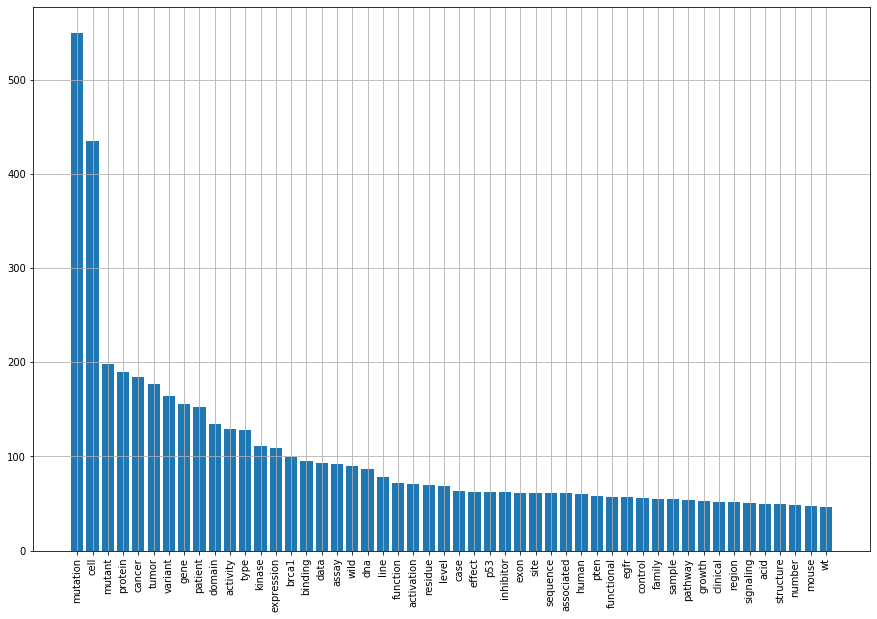

The top 50 words and their frequencies are 28743      mutation
8529           cell
28728        mutant
34781       protein
7744         cancer
44162         tumor
45650       variant
18068          gene
32167       patient
13330        domain
2984       activity
44302          type
24011        kinase
15711    expression
6906          brca1
6326        binding
11766          data
5134          assay
46520          wild
13258           dna
25458          line
17223      function
2963     activation
37286       residue
25292         level
8020           case
14350        effect
31615           p53
22292     inhibitor
15591          exon
39973          site
39309      sequence
5179     associated
20891         human
35070          pten
17228    functional
14388          egfr
10312       control
16099        family
38678        sample
32142       pathway
19009        growth
9389       clinical
36916        region
39828     signaling
2888           acid
41203     structure
30459        numb

In [168]:
print("The top 50 words and their frequencies are", top_x_features_plot(text_ohe_features_en, text_ohe_train_en, 50))

Visualization of all the words and their frequencies

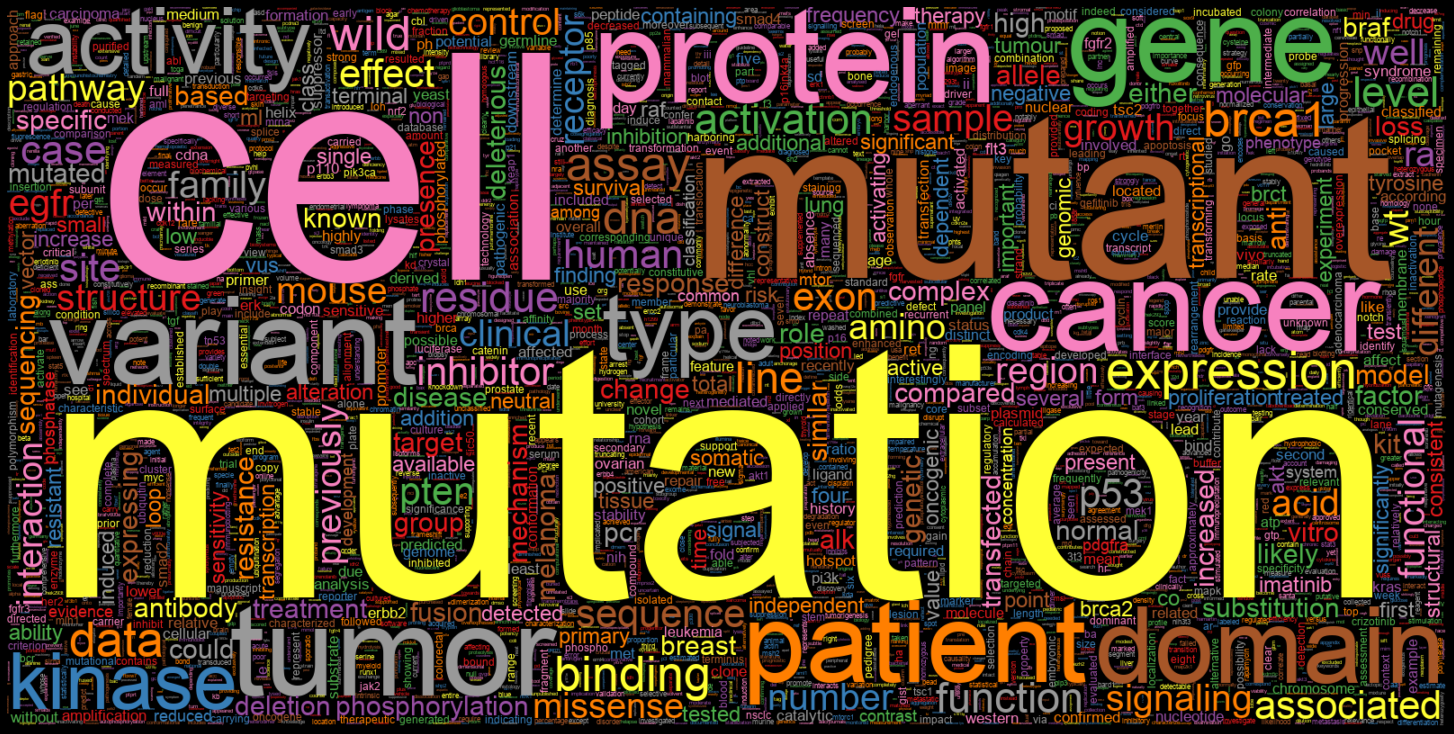

In [169]:
word_cloud_plot(text_ohe_features_en, text_ohe_train_en)

What are the top 20 words with highest frequency in the text corpus for every "target" class variable?


In [171]:
top_n_words_per_target_class(text_ohe_features_en, text_ohe_train_en.toarray(), 20)

0         1        2       3           4            5        6  \
0  mutation      cell  protein  cancer     variant         gene   mutant   
1  mutation      cell  patient   tumor        gene       cancer   kinase   
2  mutation      cell  variant  cancer      mutant        brca1    assay   
3  mutation      cell  protein    pten      mutant     activity  variant   
4  mutation   variant    brca1    cell       assay       cancer  protein   
5  mutation   variant    brca1    cell       tumor  deleterious   cancer   
6  mutation      cell   mutant   tumor     patient       kinase   cancer   
7      cell  mutation     gene   tumor  expression         bcor     idh1   
8      cell  mutation   mutant   sf3b1        gene     splicing     ezh2   

            7        8           9        10          11          12  \
0         p53    tumor        type    domain     binding         dna   
1      mutant  protein        exon    fusion        egfr        type   
2        mtor      alk     protein    domain     patient    activity   
3      cancer     type       tumor      gene      domain  expression   
4  functional   domain        type  activity      mutant         vus   
5      domain  protein      family      data       brca2        type   
6        gene   domain     protein  activity  expression  activation   
7      mutant  protein      cancer      idh2          h3      sample   
8        type     idh1  expression   protein       u2af1        wild   

           13          14        15          16        17          18  \
0  expression        wild  activity     patient     brca1       assay   
1      domain         kit      case  expression  activity        line   
2      kinase  expression      type      pdgfra      gene  functional   
3     binding         p53      wild    function     assay         dna   
4        data        gene     tumor        wild   neutral     binding   
5    sequence     binding     model      kinase      gene      mutant   
6        egfr   inhibitor      type        line   pathway   signaling   
7         dna        data   histone         2hg      type      allele   
8      sample       level       2hg          wt    cancer        site   

         19  
0  function  
1      braf  
2     tumor  
3   patient  
4      brct  
5      site  
6    growth  
7   patient  
8     tumor

How significant is the "Text" feature in predicting class?

In [172]:
sgd_classifier(text_ohe_train_en.toarray(),y_train,text_ohe_cv_en.toarray(),y_cv, text_ohe_test_en.toarray(), y_test)[0]

1.0432171365493081

How stable is the text feature?

In [173]:
# How stable is the text feature?
# Determine the percentage of cv and text data in train.
#text_dict #<-- Training data from count vectorizer with df_min = 3
def create_text_dict(series):
    '''Returns a dictionary of the words present in the given series and their frequency'''
    words = []
    for doc in series:
            for w in doc.split():
                words.append(w)
    return collections.Counter(words)

In [174]:
text_dict_train = create_text_dict(X_train['Text'])
text_dict_cv = create_text_dict(X_cv['Text'])
text_dict_test = create_text_dict(X_test['Text'])

print("Length of train dictionary:",len(text_dict_train))
print("Length of cv dictionary:",len(text_dict_cv))
print("Length of test dictionary:",len(text_dict_test))


Length of train dictionary: 389503
Length of cv dictionary: 192905
Length of test dictionary: 209608


In [175]:
print("Amount of cv data overlapped with train data {:.2f}%".format(100 - (len([word for word in text_dict_cv if word not in text_dict_train])/len(text_dict_train))*100))
print("Amount of test data overlapped with train data {:.2f}%".format(100 - (len([word for word in text_dict_test if word not in text_dict_train])/len(text_dict_train))*100))

Amount of cv data overlapped with train data 89.08%
Amount of test data overlapped with train data 85.44%


About 86% of Test and CV text data overlaps with the train data. This feature is mostly stable and will be retained

Summary of Univariate analysis:
    - Logistic loss of univariate models of Gene, Variation and text features are lower than the logistic loss calculated from random model. This indicates that all 3 of these features are significant in predicting the class label. All three of these features will be retained
    - Gene is the most stable feature across train, cv and test dataset. The next stable is text. Variation is a unstable feature
    - Further text preprocessing is required to extract scientific terminologies    

### 3.3 Bivariate Analysis
#### 3.3.1 Bivariate analysis of Gene and Variation features

Unique combinations of Gene and Variation

In [196]:
X_train.duplicated(subset= ['Gene','Variation']).any()

False

Are Gene and Variation feature independent of each other? Let's check with Chi2 test

In [176]:
contingency_table = pd.crosstab(X_train.Gene, X_train.Variation)
contingency_table

Variation  1_2009trunc  2010_2471trunc  385_418del  422_605trunc  550_592del  \
Gene                                                                           
ABL1                 0               0           0             0           0   
ACVR1                0               0           0             0           0   
AGO2                 0               0           0             0           0   
AKT1                 0               0           0             0           0   
AKT2                 0               0           0             0           0   
...                ...             ...         ...           ...         ...   
VHL                  0               0           0             0           0   
WHSC1                0               0           0             0           0   
XPO1                 0               0           0             0           0   
XRCC2                0               0           0             0           0   
YAP1                 0               0           0             0           0   

Variation  560_561insER  A1022E  A111P  A1131T  A113_splice  ...  Y842C  \
Gene                                                         ...          
ABL1                  0       0      0       0            0  ...      0   
ACVR1                 0       0      0       0            0  ...      0   
AGO2                  0       0      0       0            0  ...      0   
AKT1                  0       0      0       0            0  ...      0   
AKT2                  0       0      0       0            0  ...      0   
...                 ...     ...    ...     ...          ...  ...    ...   
VHL                   0       0      0       0            0  ...      0   
WHSC1                 0       0      0       0            0  ...      0   
XPO1                  0       0      0       0            0  ...      0   
XRCC2                 0       0      0       0            0  ...      0   
YAP1                  0       0      0       0            0  ...      0   

Variation  Y849S  Y87C  Y87N  Y901C  Y931C  Y98N  YAP1-FAM118B Fusion  \
Gene                                                                    
ABL1           0     0     0      0      0     0                    0   
ACVR1          0     0     0      0      0     0                    0   
AGO2           0     0     0      0      0     0                    0   
AKT1           0     0     0      0      0     0                    0   
AKT2           0     0     0      0      0     0                    0   
...          ...   ...   ...    ...    ...   ...                  ...   
VHL            0     0     0      0      0     1                    0   
WHSC1          0     0     0      0      0     0                    0   
XPO1           0     0     0      0      0     0                    0   
XRCC2          0     0     0      0      0     0                    0   
YAP1           0     0     0      0      0     0                    1   

Variation  ZC3H7B-BCOR Fusion  ZNF198-FGFR1 Fusion  
Gene                                                
ABL1                        0                    0  
ACVR1                       0                    0  
AGO2                        0                    0  
AKT1                        0                    0  
AKT2                        0                    0  
...                       ...                  ...  
VHL                         0                    0  
WHSC1                       0                    0  
XPO1                        0                    0  
XRCC2                       0                    0  
YAP1                        0                    0  

[235 rows x 1925 columns]

In [177]:
## Hypothesis test: Independent test between features Gene and Variation
## alpha = 0.5
# Null hypothesis: Features are independent of each other
print("Chi2 statistic: {:.4f}\n p-value:{:.4f}\n \
      DOF: {}\n Expected values: {}\n".format(*chi2_contingency(contingency_table)))

Chi2 statistic: 338358.9346
 p-value:1.0000
       DOF: 450216
 Expected values: [[0.00753296 0.00753296 0.00753296 ... 0.00753296 0.00753296 0.00753296]
 [0.00141243 0.00141243 0.00141243 ... 0.00141243 0.00141243 0.00141243]
 [0.00188324 0.00188324 0.00188324 ... 0.00188324 0.00188324 0.00188324]
 ...
 [0.00094162 0.00094162 0.00094162 ... 0.00094162 0.00094162 0.00094162]
 [0.00094162 0.00094162 0.00094162 ... 0.00094162 0.00094162 0.00094162]
 [0.00094162 0.00094162 0.00094162 ... 0.00094162 0.00094162 0.00094162]]



Since the p-value is 1, greater than 0.5, we fail to reject the null hypothesis. Thus, Gene and Variations are independent of each other.

<I>Modelling with Gene and variation to predict the "Gene mutation" class </I>

In [178]:
## Classification matric functions

def classification_kpi(x, truey, model):
    '''Returns the logistic loss and confusion matrix of the model'''
    y = model.predict(x)
    y_prob = model.predict_proba(x)
    return (log_loss(truey, y_prob), confusion_matrix(truey, y), precision_recall_fscore_support(truey, y))   

def plot_cm_precision_recall_curves(cm):
    '''Returns seaborn heatmap plots of confusion matrix, precision and recall values'''
    plots = ['Confusion Matrix', 'Precision', 'Recall']
    classification_metric_heatmap(cm, "Confusion Matrix")
    classification_metric_heatmap(cm/cm.sum(axis=0), "Precision")
    classification_metric_heatmap(cm/cm.sum(axis=1).reshape(9,1), "Recall")
        
def classification_metric_heatmap(data, title):
    '''Returns seaborn heatmap of given data'''
    tick_labels = range(1,10)
    plt.title(title)
    sns.heatmap(data, cmap = 'Blues', annot = True, xticklabels=tick_labels, yticklabels=tick_labels)
    plt.ylabel("Actual Class")
    plt.xlabel("Predicted Class")
    plt.show()

In [179]:
#Bivariate analysis of gene and variation

### One hot encoded gene and variation
bivar_X_train_val = np.hstack((gene_ohe_train_norm.toarray(), var_ohe_train_norm.toarray()))
bivar_X_cv_val = np.hstack((gene_ohe_cv_norm.toarray(), var_ohe_cv_norm.toarray()))
bivar_X_test_val = np.hstack((gene_ohe_test_norm.toarray(), var_ohe_test_norm.toarray()))
ohe_features = np.hstack((gene_ohe_features, var_ohe_features))

### Response coded gene and variation
bivar_X_train_ohe_rc = np.hstack((gene_rc_train_norm, var_rc_train_norm))
bivar_X_cv_ohe_rc = np.hstack((gene_rc_cv_norm, var_rc_cv_norm))
bivar_X_test_ohe_rc = np.hstack((gene_rc_test_norm, var_rc_test_norm))

gene_rc_features = ["gene_prob_class_"+str(i) for i in range(1,10)]
var_rc_features = ["var_prob_class_"+str(i) for i in range(1,10)]

bivar_ohe_rc_features = np.hstack((gene_rc_features, var_rc_features))



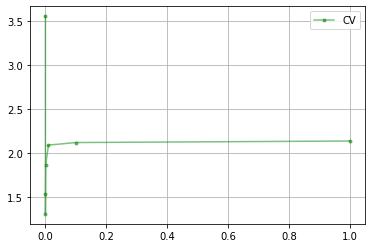

In [180]:
#2.1 Logistic regression with L2 regularization and 'balanced' class weight
alpha = [1e-6, 1e-5,1e-4, 1e-3, 1e-2, 1e-1, 1]
logloss_cv = []
for a in alpha:
    lr_l2_bal = SGDClassifier(alpha = a, loss = 'log', l1_ratio = 0,class_weight='balanced')#loss)
    lr_l2_bal.fit(bivar_X_train_val,y_train)
    logloss_cv.append(classification_metric(y_cv, lr_l2_bal, bivar_X_cv_val)[0])
plt.plot(alpha, logloss_cv, marker = ".", c = "g", label = "CV", alpha =0.5)
plt.legend()
plt.grid()

Log loss of Train data: 0.5944530715841057
Log loss of CV data: 1.318712722718771
Log loss of Test data: 1.3501572822955576
Model accuracy: 56.2030%


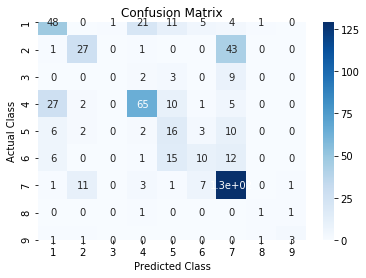

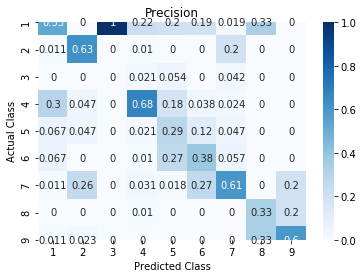

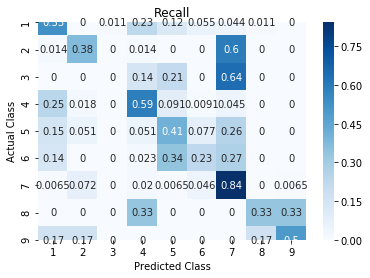

In [181]:
## Minimum alpha
best_alpha = alpha[np.argmin(logloss_cv)]

params = {'alpha': best_alpha}
lr_l2_bal.set_params(**params)
lr_l2_bal.fit(bivar_X_train_val,y_train)
print("Log loss of Train data:", classification_kpi(bivar_X_train_val,y_train, lr_l2_bal)[0])
print("Log loss of CV data:", classification_kpi(bivar_X_cv_val,y_cv, lr_l2_bal)[0])
print("Log loss of Test data:", classification_kpi(bivar_X_test_val,y_test, lr_l2_bal)[0])
print("Model accuracy: {:.4f}%".format(accuracy_score(y_cv, lr_l2_bal.predict(bivar_X_cv_val))*100))
plot_cm_precision_recall_curves(classification_kpi(bivar_X_cv_val,y_cv, lr_l2_bal)[1])

Summary of bi-variate analysis

- Gene and variation features are independent of each other
- Gene and variation features alone can predict about 56% of the gene mutation classes